# Calculation of diffusion coefficient

## 1.-Preparation

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from scipy.optimize import curve_fit
from scipy import stats, polyval

In [24]:
name = "1_t3"
h5 = h5py.File('/home/oriol/calculs/test/h5_cfg/histograms/pdists/pdist1_t3_1.h5')

In [25]:
print("Data inside h5 file:")
for k in h5:
    print("\t -",k)

Data inside h5 file:
	 - binbounds_0
	 - histograms
	 - midpoints_0
	 - n_iter


The histogram has columns on the sides that are full of 0, so these columns from both sides of histogram are removed

In [26]:
arr_h5 = np.array(h5["histograms"])
print("Original shape:",arr_h5.shape)
mask = np.all(arr_h5 == 0, axis=0)
arr_h5 = np.compress(~mask,arr_h5,axis=1)
midpoints_h5 = np.compress(~mask,np.array(h5["midpoints_0"]),axis=0)
print("Shape without empty columns:",arr_h5.shape)
print("Position of occupied bins:\n",midpoints_h5)

Original shape: (155, 280)
Shape without empty columns: (155, 42)
Position of occupied bins:
 [-40.5 -39.5 -38.5 -37.5 -36.5 -35.5 -34.5 -33.5 -32.5 -31.5 -30.5 -29.5
 -28.5 -27.5 -26.5 -25.5 -24.5 -23.5 -22.5 -21.5 -20.5 -19.5 -18.5 -17.5
 -16.5 -15.5 -14.5 -13.5 -12.5 -11.5 -10.5  -9.5  -8.5  -7.5  -6.5  -5.5
  -4.5  -3.5  -2.5  -1.5  -0.5   0.5]


## 1.- Polynomial fitting

### 1.1 Define the function

The function that is used on the fitting has a second term to obtain central values(x0) of the optimization that are closer to the real distribution centre. This value can be defined manually (a) or automatically as the centre of the distribution in the first iteration (b).

In [27]:
#a
centre = -14.5

In [28]:
#b
centre = np.mean(midpoints_h5[np.where(arr_h5[0] != 0)])

In [29]:
def func(x,x0,s):
    return -(x-x0)**2/s + 0.1*(x0-centre)**2 

A normal distribution follows:  
\begin{align}
f(x) = e^{-(x-x_0)^{2}/s} \\ 
s = 2σ² = 4Dt 
\end{align}
But the fitting takes the logarithm of that function

/home/oriol/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys
/home/oriol/miniconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:785: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/oriol/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


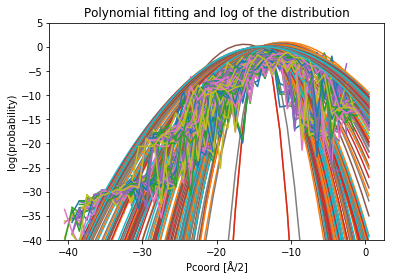

In [42]:
xdata = midpoints_h5
s_value = []
s_estimation = 1
for i in h5["n_iter"]:
    ydata = arr_h5[i-1]
    try:
        valid = np.isfinite(np.log(ydata)) 
        popt, pcov = curve_fit(func, xdata[valid], np.log(ydata[valid]), p0=[centre, s_estimation])
        plt.plot(xdata, np.log(ydata))
        plt.plot(xdata, func(xdata, *popt))
    except TypeError:
        popt = [np.nan, np.nan]
    except RuntimeError:
        popt = [np.nan, np.nan]
    s_value.append(popt) #s_value[0] = x0, s_value[1] = s
sq_sigma=np.array(s_value)[:,1]/2
plt.ylim(-40,5)
plt.xlabel("Pcoord [Å/2]")
plt.ylabel("log(probability)")
plt.title("Polynomial fitting and log of the distribution")
#plt.savefig("log(distr){}".format(name))
plt.show()

The variance can be plotted versus the time(or iterations) and do a linear regression:
\begin{align}
σ² = 2Dt
\end{align}
The slope (2·D) is given in [Å²/iteration] and is converted to diffusion coefficient in [μm²/s], given that each iteration is 40ps.

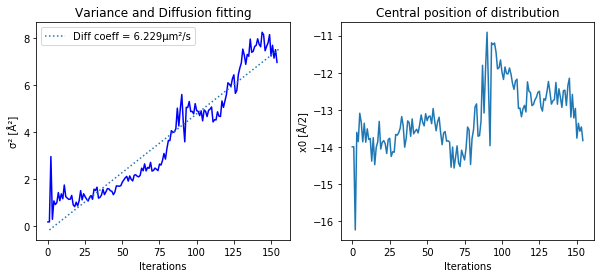

Diffusion coefficient(1_t3) = 6.229 μm²/s


In [45]:
regr_h5, cov = np.polyfit(h5["n_iter"],sq_sigma,1, cov=True)
diff_coeff_h5 = regr_h5[0]*1e4/(2*40)
diff_coeff = round(diff_coeff_h5, 3)

plt.figure(figsize=(10,4))
line1 = polyval([regr_h5[0],regr_h5[1]],h5["n_iter"])
plt.subplot(121)
plt.plot(sq_sigma, "b")
plt.plot(h5["n_iter"],line1, ":", label="Diff coeff = {}μm²/s".format(diff_coeff))
plt.title("Variance and Diffusion fitting")
plt.xlabel("Iterations")
plt.ylabel("σ² [Å²]")
plt.legend()

plt.subplot(122)
plt.plot(s_h5[:,0])
plt.title("Central position of distribution")
plt.xlabel("Iterations")
plt.ylabel("x0 [Å/2]")
#plt.savefig("Diff_Position_{}".format(name))
plt.show()

print("Diffusion coefficient({}) = {} μm²/s".format(name,diff_coeff))